# MORPC Insights - Crash Injuries and Fatalities

## Overview

The Ohio Department of Transportation maintains a database of vehicle crash indidents, including the injuries and fatalities that sometimes result from them.  Each year, typically in the spring, MORPC receives an extract of this data that ODOT has cleaned.  This notebook produces a summary of injuries and fatalities based on the cleaned data.
  
This notebook produces a tileset that includes a summary of injuries and fatalities for 13 of the counties in the MORPC 15-county region and a selection of counties outside of this region.  The included counties in the MORPC region are Delaware*, Fairfield*, Franklin*, Knox*, Licking*, Madison*, Marion*, Morrow*, Perry, Pickaway*, Ross, Union*.  A summary is also produced for the MORPC 10-County Region, which includes the counties denoted with asterisks.

## Setup

### Load required libraries

In [1]:
import pandas as pd
import frictionless
import requests
import os
import sys
import json
import datetime
import textwrap
import matplotlib
from matplotlib import pyplot as plt
sys.path.append(os.path.normpath("../morpc-common"))
import morpc

### User-specified parameters

In [2]:
# Year range is the range of years that will be included in output tables that are indexed by year
YEAR_RANGE = [2019, 2023]

# Summary range is the range of years that will be included when computing summaries
SUMMARY_RANGE = [2019, 2023]

### Static parameters

In [3]:
INPUT_DIR = os.path.normpath("./input_data")

OUTPUT_DIR = os.path.normpath("./output_data")

CHART_DIRNAME = "charts"

SELECTED_GEOS = ['Delaware', 'Fairfield', 'Franklin', 'Knox', 'Licking', 
                 'Madison', 'Marion', 'Morrow', 'Pickaway', 'Union', 'Region10']

# Dictionary mapping county codes to county names
COUNTY_CODE_MAP = {
    'CRA': 'Crawford',
    'DEL': 'Delaware',
    'FAI': 'Fairfield',
    'FRA': 'Franklin',
    'HAN': 'Hancock',
    'HAR': 'Hardin',
    'KNO': 'Knox',
    'LIC': 'Licking',
    'LOG': 'Logan',
    'MAD': 'Madison',
    'MAR': 'Marion',
    'MOT': 'Montgomery',
    'MRW': 'Morrow',
    'PER': 'Perry',
    'POR': 'Portage',
    'PIC': 'Pickaway',
    'RIC': 'Richland',
    'ROS': 'Ross',
    'SUM': 'Summit',
    'UNI': 'Union',
    'WYA': 'Wyandot'
}

OUTCOME_DESCRIPTION_MAP = {
    'INCAPAC_INJURIES_NBR':"Incapacitating injuries",
    'NON_INCAPAC_INJURIES_NBR':"Non-incapacitating injuries",
    'NO_INJURY_REPORTED_NBR':"No injuries",
    'ODPS_TOTAL_FATALITIES_NBR':"Fatality",
    'POSSIBLE_INJURIES_NBR':"Possible injuries"
}

### Define inputs

#### Create input data directory

Create input data directory if it doesn't exist.

In [4]:
inputDir = os.path.normpath(INPUT_DIR)
if not os.path.exists(inputDir):
    os.makedirs(inputDir)

#### Cleaned crash incident records

As of March 2025, the crash data is relatively large (>70MB) and therefore is not well suited for storage in GitHub.  For lack of a better repository it is stored in ArcGIS Online.  A resource file and schema are captured in GitHub to allow for validation.

In [5]:
CRASH_INPUT_URL = "https://www.arcgis.com/sharing/rest/content/items/97a9bde6b3b24358b52ca86964714f76/data"
CRASH_INPUT_TABLE_FILENAME = "MORPC_Crashes_2019-2023_GIS.csv"
CRASH_INPUT_TABLE_PATH = os.path.join(inputDir, CRASH_INPUT_TABLE_FILENAME)
CRASH_INPUT_RESOURCE_PATH = CRASH_INPUT_TABLE_PATH.replace(".csv",".resource.yaml")
CRASH_INPUT_SCHEMA_PATH = CRASH_INPUT_TABLE_PATH.replace(".csv",".schema.yaml")

### Define outputs

#### Create output data directory

Create output data directory if it doesn't exist.

In [6]:
outputDir = os.path.normpath(OUTPUT_DIR)
if not os.path.exists(outputDir):
    os.makedirs(outputDir)   

In [7]:
chartDir = os.path.join(outputDir, CHART_DIRNAME)
if not os.path.exists(chartDir):
    os.makedirs(chartDir)    

#### Crashes by geo by year (all variables)

In [8]:
OUTPUT_LONG_TABLE_FILENAME = "crashes-long.csv"
OUTPUT_LONG_TABLE_PATH = os.path.join(outputDir, OUTPUT_LONG_TABLE_FILENAME)
OUTPUT_LONG_SCHEMA_PATH = OUTPUT_LONG_TABLE_PATH.replace(".csv",".schema.yaml")
OUTPUT_LONG_RESOURCE_PATH = OUTPUT_LONG_TABLE_PATH.replace(".csv",".resource.yaml")
print("Data: {}".format(OUTPUT_LONG_TABLE_PATH))
print("Schema: {}".format(OUTPUT_LONG_SCHEMA_PATH))
print("Resource file: {}".format(OUTPUT_LONG_RESOURCE_PATH))

Data: output_data\crashes-long.csv
Schema: output_data\crashes-long.schema.yaml
Resource file: output_data\crashes-long.resource.yaml


#### Crash severity by geo by type

In [58]:
OUTPUT_CRASH_SEVERITY_BY_TYPE_FILENAME = "crashSeverityByType.csv"
OUTPUT_CRASH_SEVERITY_BY_TYPE_PATH = os.path.join(outputDir, OUTPUT_CRASH_SEVERITY_BY_TYPE_FILENAME)
OUTPUT_CRASH_SEVERITY_BY_TYPE_SCHEMA = OUTPUT_CRASH_SEVERITY_BY_TYPE_PATH.replace(".csv",".schema.yaml")
OUTPUT_CRASH_SEVERITY_BY_TYPE_RESOURCE = OUTPUT_CRASH_SEVERITY_BY_TYPE_PATH.replace(".csv",".resource.yaml")
print("Data: {}".format(OUTPUT_CRASH_SEVERITY_BY_TYPE_PATH))
print("Schema: {}".format(OUTPUT_CRASH_SEVERITY_BY_TYPE_SCHEMA))
print("Resource: {}".format(OUTPUT_CRASH_SEVERITY_BY_TYPE_RESOURCE))      

Data: output_data\crashSeverityByType.csv
Schema: output_data\crashSeverityByType.schema.yaml
Resource: output_data\crashSeverityByType.resource.yaml


#### Crash severity by geo by year

In [74]:
OUTPUT_CRASH_SEVERITY_BY_YEAR_FILENAME = "crashSeverityByYear.csv"
OUTPUT_CRASH_SEVERITY_BY_YEAR_PATH = os.path.join(outputDir, OUTPUT_CRASH_SEVERITY_BY_YEAR_FILENAME)
OUTPUT_CRASH_SEVERITY_BY_YEAR_SCHEMA = OUTPUT_CRASH_SEVERITY_BY_YEAR_PATH.replace(".csv",".schema.yaml")
OUTPUT_CRASH_SEVERITY_BY_YEAR_RESOURCE = OUTPUT_CRASH_SEVERITY_BY_YEAR_PATH.replace(".csv",".resource.yaml")
print("Data: {}".format(OUTPUT_CRASH_SEVERITY_BY_YEAR_PATH))
print("Schema: {}".format(OUTPUT_CRASH_SEVERITY_BY_YEAR_SCHEMA))
print("Resource: {}".format(OUTPUT_CRASH_SEVERITY_BY_YEAR_RESOURCE))      

Data: output_data\crashSeverityByYear.csv
Schema: output_data\crashSeverityByYear.schema.yaml
Resource: output_data\crashSeverityByYear.resource.yaml


#### Crash severity by geo by mode

In [79]:
OUTPUT_CRASH_SEVERITY_BY_MODE_FILENAME = "crashSeverityByMode.csv"
OUTPUT_CRASH_SEVERITY_BY_MODE_PATH = os.path.join(outputDir, OUTPUT_CRASH_SEVERITY_BY_MODE_FILENAME)
OUTPUT_CRASH_SEVERITY_BY_MODE_SCHEMA = OUTPUT_CRASH_SEVERITY_BY_MODE_PATH.replace(".csv",".schema.yaml")
OUTPUT_CRASH_SEVERITY_BY_MODE_RESOURCE = OUTPUT_CRASH_SEVERITY_BY_MODE_PATH.replace(".csv",".resource.yaml")
print("Data: {}".format(OUTPUT_CRASH_SEVERITY_BY_MODE_PATH))
print("Schema: {}".format(OUTPUT_CRASH_SEVERITY_BY_MODE_SCHEMA))
print("Resource: {}".format(OUTPUT_CRASH_SEVERITY_BY_MODE_RESOURCE))      

Data: output_data\crashSeverityByMode.csv
Schema: output_data\crashSeverityByMode.schema.yaml
Resource: output_data\crashSeverityByMode.resource.yaml


## Prepare input data

### Load cleaned crash incident records

Load incident records from ArcGIS online and save a local copy.  If a local copy exists, use that instead.

In [9]:
if(os.path.exists(CRASH_INPUT_TABLE_PATH)):
    print("Using existing local copy of crash incident data found at {}".format(CRASH_INPUT_TABLE_PATH))
    crashesRaw = pd.read_csv(CRASH_INPUT_TABLE_PATH)
else:
    print("Downloading crash incident data from ArcGIS Online and saving a copy at {}".format(CRASH_INPUT_TABLE_PATH))
    crashesRaw = pd.read_csv(CRASH_INPUT_URL)
    crashesRaw.to_csv(CRASH_INPUT_TABLE_PATH, index=False)

Using existing local copy of crash incident data found at input_data\MORPC_Crashes_2019-2023_GIS.csv


Validate the crash incident dataset.

In [10]:
valid = morpc.frictionless_validate_resource(CRASH_INPUT_RESOURCE_PATH)
if(not valid):
    print("Validation of crash incident data failed.  Inspect the data and ensure it matches the resource file and schema, then try again.")
    raise RuntimeError

morpc.frictionless_validate_resource | INFO | Validating resource on disk (including data and schema). This may take some time.
morpc.frictionless_validate_resource | INFO | Resource is valid


Inspect the data.

In [11]:
crashesRaw.head()

,Document_Number,Year,SEVERITY_BY_TYPE_CD,CRASH_TYPE_CD,DISTRICT_NBR,NLF_COUNTY_CD,ODOT_CRASH_LOCATION_CD,NLFID,ODOT_LATITUDE_NBR,ODOT_LONGITUDE_NBR,...,ODPS_SCHOOL_ZONE_IND,ODPS_MOTORCYCLE_IND,ODPS_SPEED_IND,ODPS_SENIOR_DRIVER_IND,ODOT_YOUNG_DRIVER_IND,ODPS_WORK_ZONE_IND,ODPS_LOC_IN_WORK_ZONE_CD,ODPS_TYPE_OF_WORK_ZONE_CD,DISTRACTED_DRIVER_IND,ODPS_CITY_VILLAGE_TWP_NME
0,20223225874,2022,(5) PDO/No Injury,Rear End,6,FRA,Not An Intersection,SFRASR00161**N,40.091010,-82.812029,...,No,No,Yes,No,Yes,No,Unknown or Not in Work Zone,Unknown or Not in Work Zone,No,NEW ALBANY
1,20223204693,2022,(3) Minor Injury Suspected,Angle,6,FRA,Not An Intersection,CFRACR00017**C,40.059121,-82.944677,...,No,No,No,No,No,No,Unknown or Not in Work Zone,Unknown or Not in Work Zone,No,COLUMBUS
2,20223204715,2022,(5) PDO/No Injury,Sideswipe - Passing,6,FRA,Other,MFRAMR04207**C,39.945766,-82.798491,...,No,No,No,No,No,No,Unknown or Not in Work Zone,Unknown or Not in Work Zone,No,REYNOLDSBURG
3,20213191491,2021,(5) PDO/No Injury,Parked Vehicle,6,FRA,Not An Intersection,MFRAMR00670**C,39.977089,-82.998042,...,No,No,No,No,No,No,Unknown or Not in Work Zone,Unknown or Not in Work Zone,No,COLUMBUS
4,20215201895,2021,(5) PDO/No Injury,Parked Vehicle,6,MAR,Not An Intersection,SMARSR00004**C,40.659114,-83.114080,...,No,No,Yes,No,Yes,No,Unknown or Not in Work Zone,Unknown or Not in Work Zone,No,GRAND PRAIRIE TOWNSHIP


In [12]:
crashesRaw["SEVERITY_BY_TYPE_CD"].value_counts()

SEVERITY_BY_TYPE_CD
(5) PDO/No Injury               145859
(3) Minor Injury Suspected       33845
(4) Injury Possible              22412
(2) Serious Injury Suspected      5294
(1) Fatal                         1030
Name: count, dtype: int64

In [13]:
crashesRaw["CRASH_TYPE_CD"].value_counts()

CRASH_TYPE_CD
Rear End                      49216
Fixed Object                  31842
Sideswipe - Passing           30963
Angle                         30806
Left Turn                     13670
Parked Vehicle                13090
Animal                        10178
Backing                        7572
Right Turn                     6179
Head On                        4197
Pedestrian                     2951
Other Non-Collision            2918
Overturning                    1351
Pedalcycles                    1257
Unknown                        1190
Other Object                    929
Sideswipe - Meeting             107
Train                            21
Other Non-Vehicle                 2
Falling From Or In Vehicle        1
Name: count, dtype: int64

In [14]:
crashesRaw[['ODPS_TOTAL_FATALITIES_NBR','INCAPAC_INJURIES_NBR','NON_INCAPAC_INJURIES_NBR','POSSIBLE_INJURIES_NBR','NO_INJURY_REPORTED_NBR']].describe()

,ODPS_TOTAL_FATALITIES_NBR,INCAPAC_INJURIES_NBR,NON_INCAPAC_INJURIES_NBR,POSSIBLE_INJURIES_NBR,NO_INJURY_REPORTED_NBR
count,208440.000000,208440.000000,208440.000000,208440.000000,208440.000000
mean,0.005325,0.031290,0.222390,0.171541,1.949367
std,0.079098,0.207538,0.567268,0.512699,1.768849
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,2.000000
75%,0.000000,0.000000,0.000000,0.000000,2.000000
max,6.000000,13.000000,22.000000,11.000000,110.000000


## Transform data to format required by Insights platform

### Simplify crash data

Create a working copy.

In [15]:
crashes = crashesRaw.copy()

Convert three-letter county codes to county names.

In [16]:
crashes['GEONAME'] = crashes['NLF_COUNTY_CD'].map(COUNTY_CODE_MAP)

Rename year column to make it match other columns.

In [17]:
crashes = crashes.rename(columns={"Year":"YEAR"})

Extract only the records from the selected counties.

In [18]:
crashes = crashes.loc[crashes["GEONAME"].isin(SELECTED_GEOS)].copy()

Remove the numeric prefix from the crash severity categories.

In [19]:
crashes["SEVERITY_BY_TYPE_CD"] = crashes["SEVERITY_BY_TYPE_CD"].apply(lambda x:x.split(" ", maxsplit=1)[1])

Extract only the columns that we need.

In [20]:
crashes = crashes.filter(items=['GEONAME','YEAR','SEVERITY_BY_TYPE_CD','CRASH_TYPE_CD'], axis="columns")

Summarize the crashes by county, year, crash type, and severity.

In [21]:
crashes['CRASHES'] = 1
crashes = crashes \
    .groupby(['GEONAME','YEAR','CRASH_TYPE_CD','SEVERITY_BY_TYPE_CD']).sum() \
    .sort_values(['GEONAME','YEAR','CRASH_TYPE_CD','SEVERITY_BY_TYPE_CD']) \
    .reset_index()

Summarize the crashes for the 10-county region.

In [22]:
temp = crashes.copy() \
    .drop(columns="GEONAME") \
    .groupby(['YEAR','CRASH_TYPE_CD','SEVERITY_BY_TYPE_CD']).sum() \
    .reset_index()
temp["GEONAME"] = "Region10"
crashes = pd.concat([crashes, temp], axis="index")

Inspect the data.

In [23]:
crashes

,GEONAME,YEAR,CRASH_TYPE_CD,SEVERITY_BY_TYPE_CD,CRASHES
0,Delaware,2019,Angle,Fatal,2
1,Delaware,2019,Angle,Injury Possible,77
2,Delaware,2019,Angle,Minor Injury Suspected,112
3,Delaware,2019,Angle,PDO/No Injury,303
4,Delaware,2019,Angle,Serious Injury Suspected,13
...,...,...,...,...,...
415,Region10,2023,Unknown,Fatal,1
416,Region10,2023,Unknown,Injury Possible,8
417,Region10,2023,Unknown,Minor Injury Suspected,26
418,Region10,2023,Unknown,PDO/No Injury,205


In [24]:
crashes[["GEONAME","YEAR","CRASHES"]].groupby(["GEONAME","YEAR"]).sum().reset_index().pivot(index="GEONAME",columns="YEAR",values="CRASHES")

YEAR,2019,2020,2021,2022,2023
GEONAME,,,,,
Delaware,4009,3174,3441,3557,3485
Fairfield,2819,2354,2818,2658,2118
Franklin,34210,21856,22769,22636,23592
Knox,1233,986,1115,1101,1051
Licking,3658,3325,3693,3461,3178
Madison,1181,955,990,1015,1058
Marion,1655,1485,1600,1579,1512
Morrow,952,813,853,875,922
Pickaway,1346,1166,1287,1286,1236


### Summarize crash severity by geography by year

In [25]:
crashSeverityByGeoByYear = crashes \
    .drop(columns=["CRASH_TYPE_CD"]) \
    .groupby(["GEONAME","YEAR","SEVERITY_BY_TYPE_CD"]).sum().reset_index() \
    .pivot(index=["GEONAME","YEAR"], columns=["SEVERITY_BY_TYPE_CD"], values="CRASHES") \
    .rename(columns={
        "Fatal":"GEO_YEAR_FATAL",
        "Injury Possible":"GEO_YEAR_POSSIBLE",
        "Minor Injury Suspected":"GEO_YEAR_MINOR",
        "PDO/No Injury":"GEO_YEAR_NOINJ",
        "Serious Injury Suspected":"GEO_YEAR_SERIOUS"
    }) \
    .filter(items=["GEO_YEAR_FATAL", "GEO_YEAR_SERIOUS", "GEO_YEAR_MINOR", "GEO_YEAR_POSSIBLE", "GEO_YEAR_NOINJ"], axis="columns") \

crashSeverityByGeoByYear["GEO_YEAR_TOTAL"] = crashSeverityByGeoByYear.sum(axis="columns")

crashSeverityByGeoByYear.columns.name = None
crashSeverityByGeoByYear.head()

GEO_YEAR_FATAL  GEO_YEAR_SERIOUS  GEO_YEAR_MINOR  \
GEONAME  YEAR                                                     
Delaware 2019              13                67             509   
         2020              15                84             423   
         2021               9                80             495   
         2022              17                87             485   
         2023              15                81             485   

               GEO_YEAR_POSSIBLE  GEO_YEAR_NOINJ  GEO_YEAR_TOTAL  
GEONAME  YEAR                                                     
Delaware 2019                483            2937            4009  
         2020                336            2316            3174  
         2021                435            2422            3441  
         2022                443            2525            3557  
         2023                420            2484            3485

In [26]:
crashSeverityByGeoByYear.reset_index()[["GEONAME","YEAR","GEO_YEAR_FATAL"]].pivot(index="GEONAME",columns="YEAR",values="GEO_YEAR_FATAL")

YEAR,2019,2020,2021,2022,2023
GEONAME,,,,,
Delaware,13,15,9,17,15
Fairfield,13,16,17,12,15
Franklin,101,117,118,118,118
Knox,7,6,5,9,6
Licking,22,15,24,17,17
Madison,5,7,2,10,10
Marion,8,8,10,9,10
Morrow,6,1,7,9,5
Pickaway,13,10,10,9,7


In [27]:
crashSeverityByGeoByYear.reset_index()[["GEONAME","YEAR","GEO_YEAR_SERIOUS"]].pivot(index="GEONAME",columns="YEAR",values="GEO_YEAR_SERIOUS")

YEAR,2019,2020,2021,2022,2023
GEONAME,,,,,
Delaware,67,84,80,87,81
Fairfield,80,80,98,67,79
Franklin,585,563,644,536,550
Knox,36,26,28,32,27
Licking,71,99,110,134,99
Madison,47,33,45,47,54
Marion,32,29,47,36,40
Morrow,31,18,30,23,28
Pickaway,46,44,42,54,57


### Summarize crash severity by geography for all years

In [28]:
crashSeverityByGeo = crashSeverityByGeoByYear.copy() \
    .reset_index() \
    .drop(columns="YEAR") \
    .groupby("GEONAME").sum() \
    .rename(columns=(lambda column:column.replace("GEO_YEAR","GEO")))
crashSeverityByGeo

,GEO_FATAL,GEO_SERIOUS,GEO_MINOR,GEO_POSSIBLE,GEO_NOINJ,GEO_TOTAL
GEONAME,,,,,,
Delaware,69,399,2397,2117,12684,17666
Fairfield,73,404,1837,1181,9272,12767
Franklin,572,2878,22053,14634,84926,125063
Knox,33,149,762,412,4130,5486
Licking,95,513,2327,1524,12856,17315
Madison,34,226,766,482,3691,5199
Marion,45,184,1250,602,5750,7831
Morrow,28,130,752,274,3231,4415
Pickaway,49,243,964,567,4498,6321


### Create table of crash severity by crash type

In [29]:
crashSeverityByCrashType = crashes.loc[crashes["YEAR"].isin(range(SUMMARY_RANGE[0], SUMMARY_RANGE[1]+1))].copy() \
    .drop(columns="YEAR") \
    .groupby(["GEONAME","CRASH_TYPE_CD","SEVERITY_BY_TYPE_CD"]).sum() \
    .reset_index()

crashSeverityByCrashType = crashSeverityByCrashType.pivot(index=["GEONAME","CRASH_TYPE_CD"], columns="SEVERITY_BY_TYPE_CD", values="CRASHES") \
    .fillna(0) \
    .astype("int")

crashSeverityByCrashType.columns.name = None

crashSeverityByCrashType = crashSeverityByCrashType.rename(columns={
        "Fatal":"GEO_CRASHTYPE_FATAL",
        "Injury Possible":"GEO_CRASHTYPE_POSSIBLE",
        "Minor Injury Suspected":"GEO_CRASHTYPE_MINOR",
        "PDO/No Injury":"GEO_CRASHTYPE_NOINJ",
        "Serious Injury Suspected":"GEO_CRASHTYPE_SERIOUS"
    }) \
    .filter(items=["GEO_CRASHTYPE_FATAL", "GEO_CRASHTYPE_SERIOUS", "GEO_CRASHTYPE_MINOR", "GEO_CRASHTYPE_POSSIBLE", "GEO_CRASHTYPE_NOINJ"], axis="columns") \

crashSeverityByCrashType["GEO_CRASHTYPE_TOTAL"] = crashSeverityByCrashType.sum(axis="columns")

crashSeverityByCrashType = crashSeverityByCrashType.reset_index()                                                          

crashSeverityByCrashType = crashSeverityByCrashType \
    .merge(crashSeverityByGeo, on="GEONAME") \
    .set_index(["GEONAME","CRASH_TYPE_CD"])

crashSeverityByCrashType["GEO_CRASHTYPE_SHARE_OF_FATAL"] = crashSeverityByCrashType["GEO_CRASHTYPE_FATAL"] / crashSeverityByCrashType["GEO_FATAL"] 
crashSeverityByCrashType["GEO_CRASHTYPE_SHARE_OF_SERIOUS"] = crashSeverityByCrashType["GEO_CRASHTYPE_SERIOUS"] / crashSeverityByCrashType["GEO_SERIOUS"] 
crashSeverityByCrashType["GEO_CRASHTYPE_SHARE_OF_TOTAL"] = crashSeverityByCrashType["GEO_CRASHTYPE_TOTAL"] / crashSeverityByCrashType["GEO_TOTAL"] 

crashSeverityByCrashType = crashSeverityByCrashType.filter(items=[
    'GEO_CRASHTYPE_FATAL', 'GEO_CRASHTYPE_SERIOUS', 'GEO_CRASHTYPE_MINOR', 'GEO_CRASHTYPE_POSSIBLE', 'GEO_CRASHTYPE_NOINJ', 'GEO_CRASHTYPE_TOTAL',
    'GEO_CRASHTYPE_SHARE_OF_FATAL','GEO_CRASHTYPE_SHARE_OF_SERIOUS', 'GEO_CRASHTYPE_SHARE_OF_TOTAL'], axis="columns")

crashSeverityByCrashType.head()

GEO_CRASHTYPE_FATAL  GEO_CRASHTYPE_SERIOUS  \
GEONAME  CRASH_TYPE_CD                                               
Delaware Angle                           12                    101   
         Animal                           0                      7   
         Backing                          0                      0   
         Fixed Object                    23                     88   
         Head On                          9                     26   

                        GEO_CRASHTYPE_MINOR  GEO_CRASHTYPE_POSSIBLE  \
GEONAME  CRASH_TYPE_CD                                                
Delaware Angle                          519                     376   
         Animal                          51                      69   
         Backing                          8                      14   
         Fixed Object                   448                     255   
         Head On                         95                      49   

                        GEO_CRASHTYPE_NOINJ  GEO_CRASHTYPE_TOTAL  \
GEONAME  CRASH_TYPE_CD                                             
Delaware Angle                         1281                 2289   
         Animal                        1543                 1670   
         Backing                        563                  585   
         Fixed Object                  1998                 2812   
         Head On                        120                  299   

                        GEO_CRASHTYPE_SHARE_OF_FATAL  \
GEONAME  CRASH_TYPE_CD                                 
Delaware Angle                              0.173913   
         Animal                             0.000000   
         Backing                            0.000000   
         Fixed Object                       0.333333   
         Head On                            0.130435   

                        GEO_CRASHTYPE_SHARE_OF_SERIOUS  \
GEONAME  CRASH_TYPE_CD                                   
Delaware Angle                                0.253133   
         Animal                               0.017544   
         Backing                              0.000000   
         Fixed Object                         0.220551   
         Head On                              0.065163   

                        GEO_CRASHTYPE_SHARE_OF_TOTAL  
GEONAME  CRASH_TYPE_CD                                
Delaware Angle                              0.129571  
         Animal                             0.094532  
         Backing                            0.033114  
         Fixed Object                       0.159176  
         Head On                            0.016925

In [30]:
crashSeverityByCrashType.describe()

,GEO_CRASHTYPE_FATAL,GEO_CRASHTYPE_SERIOUS,GEO_CRASHTYPE_MINOR,GEO_CRASHTYPE_POSSIBLE,GEO_CRASHTYPE_NOINJ,GEO_CRASHTYPE_TOTAL,GEO_CRASHTYPE_SHARE_OF_FATAL,GEO_CRASHTYPE_SHARE_OF_SERIOUS,GEO_CRASHTYPE_SHARE_OF_TOTAL
count,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000
mean,10.500000,54.020408,345.306122,228.693878,1488.112245,2126.632653,0.056122,0.056122,0.056122
std,32.851258,149.570563,1071.585687,802.018427,4345.632227,6205.373896,0.091060,0.078584,0.070879
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000005
25%,0.000000,2.000000,7.000000,4.000000,36.000000,70.250000,0.000000,0.003764,0.006433
50%,1.000000,9.000000,36.500000,18.000000,156.000000,278.500000,0.016128,0.026549,0.021484
75%,6.000000,33.000000,159.000000,100.750000,808.750000,1199.000000,0.071429,0.069869,0.086333
max,309.000000,1277.000000,7532.000000,7329.000000,33746.000000,49214.000000,0.422222,0.429530,0.308947


<Axes: ylabel='CRASH_TYPE_CD'>

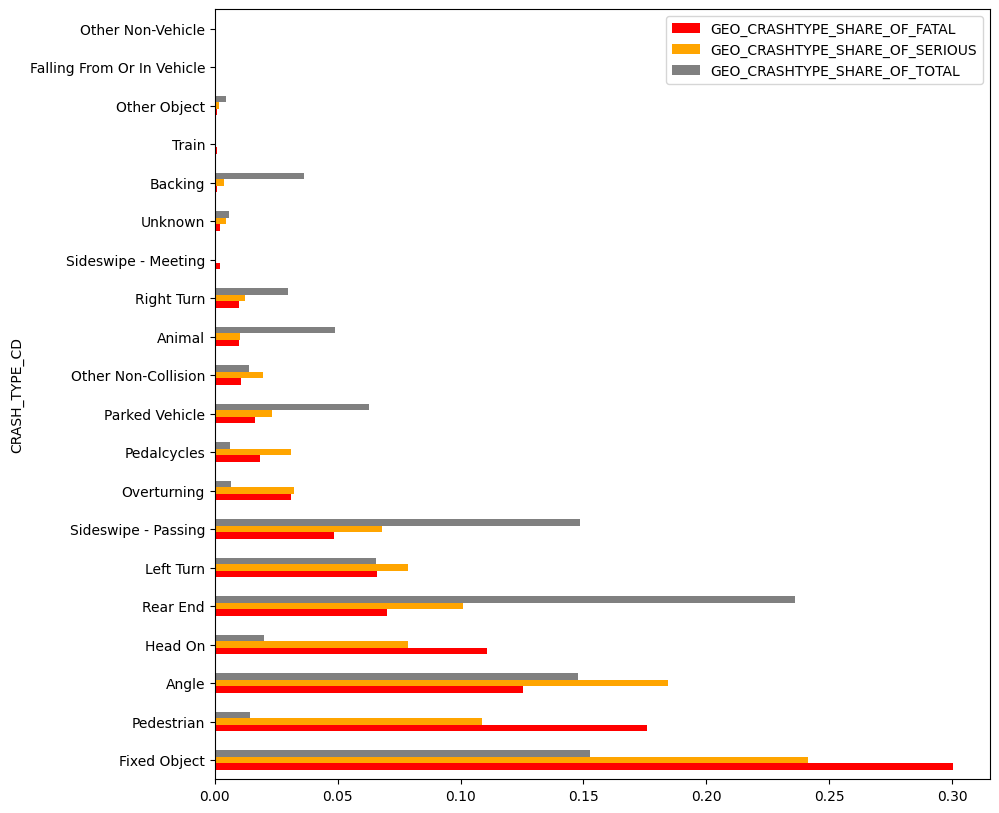

In [31]:
crashSeverityByCrashType.loc["Region10"] \
    .filter(items=['GEO_CRASHTYPE_SHARE_OF_FATAL','GEO_CRASHTYPE_SHARE_OF_SERIOUS','GEO_CRASHTYPE_SHARE_OF_TOTAL'], axis="columns") \
    .sort_values("GEO_CRASHTYPE_SHARE_OF_FATAL", ascending=False) \
    .plot.barh(color=['red','orange','grey'], figsize=(10,10))

### Create table of crash severity by year

In [41]:
crashSeverityByYear = crashSeverityByGeoByYear.copy()
crashSeverityByYear["GEO_YEAR_FATAL_RATE"] = crashSeverityByYear["GEO_YEAR_FATAL"] / (crashSeverityByYear["GEO_YEAR_TOTAL"] / 1000)
crashSeverityByYear["GEO_YEAR_SERIOUS_RATE"] = crashSeverityByYear["GEO_YEAR_SERIOUS"] / (crashSeverityByYear["GEO_YEAR_TOTAL"] / 1000)
crashSeverityByYear.head()

GEO_YEAR_FATAL  GEO_YEAR_SERIOUS  GEO_YEAR_MINOR  \
GEONAME  YEAR                                                     
Delaware 2019              13                67             509   
         2020              15                84             423   
         2021               9                80             495   
         2022              17                87             485   
         2023              15                81             485   

               GEO_YEAR_POSSIBLE  GEO_YEAR_NOINJ  GEO_YEAR_TOTAL  \
GEONAME  YEAR                                                      
Delaware 2019                483            2937            4009   
         2020                336            2316            3174   
         2021                435            2422            3441   
         2022                443            2525            3557   
         2023                420            2484            3485   

               GEO_YEAR_FATAL_RATE  GEO_YEAR_SERIOUS_RATE  
GEONAME  YEAR                                              
Delaware 2019             3.242704              16.712397  
         2020             4.725898              26.465028  
         2021             2.615519              23.249056  
         2022             4.779308              24.458814  
         2023             4.304161              23.242468

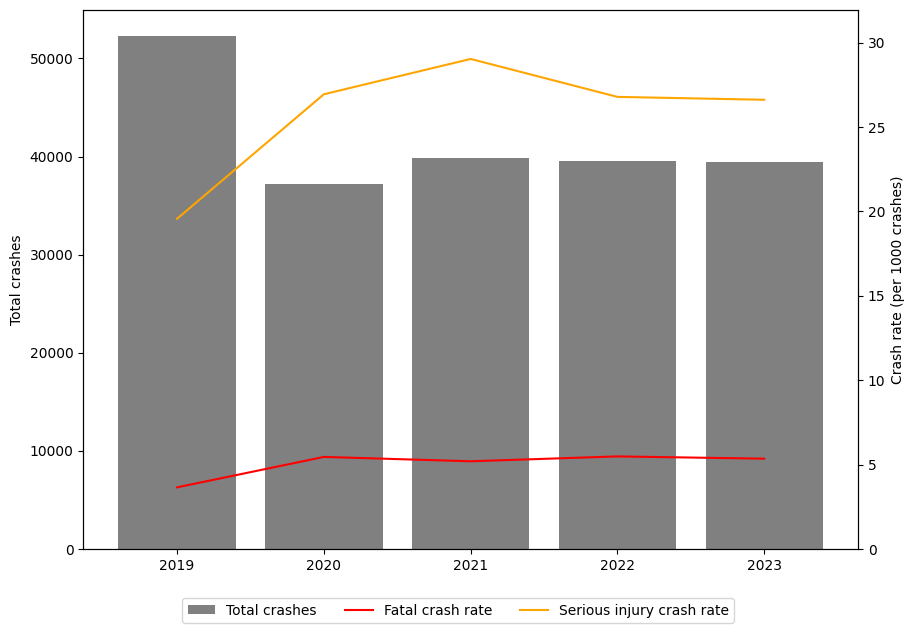

In [42]:
temp = crashSeverityByYear.loc["Region10"].copy() \
    .reset_index() \
    .filter(items=["YEAR","GEO_YEAR_TOTAL","GEO_YEAR_FATAL_RATE","GEO_YEAR_SERIOUS_RATE"])
fig, ax1 = plt.subplots(figsize=(10, 7))
ax2 = ax1.twinx()
ax1.bar(temp["YEAR"], temp["GEO_YEAR_TOTAL"], color="grey", label="Total crashes")
ax2.plot(temp["YEAR"], temp['GEO_YEAR_FATAL_RATE'], color="red", label="Fatal crash rate")
ax2.plot(temp["YEAR"], temp['GEO_YEAR_SERIOUS_RATE'], color="orange", label="Serious injury crash rate")
yMax = temp[["GEO_YEAR_FATAL_RATE","GEO_YEAR_SERIOUS_RATE"]].max().max() * 1.1
ax2.set_ylim(ymin=0, ymax=yMax)
ax2.set_ylabel("Crash rate (per 1000 crashes)")
ax1.set_ylabel("Total crashes")
ax1Handles, ax1Labels = ax1.get_legend_handles_labels()
ax2Handles, ax2Labels = ax2.get_legend_handles_labels()
legend = fig.legend(ax1Handles+ax2Handles, ax1Labels+ax2Labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3)


### Create table of crash severity by mode

In [35]:
crashSeverityByMode = crashes.copy()
crashSeverityByMode["MODE"] = "Motor Vehicle"
crashSeverityByMode.loc[crashSeverityByMode["CRASH_TYPE_CD"] == "Pedalcycles", "MODE"] = "Pedalcycles"
crashSeverityByMode.loc[crashSeverityByMode["CRASH_TYPE_CD"] == "Pedestrian", "MODE"] = "Pedestrian"

crashSeverityByMode = crashSeverityByMode \
    .drop(columns=["YEAR","CRASH_TYPE_CD"]) \
    .groupby(["GEONAME","MODE","SEVERITY_BY_TYPE_CD"]).sum() \
    .reset_index() \
    .pivot(index=["GEONAME","MODE"], columns="SEVERITY_BY_TYPE_CD", values="CRASHES") \
    .rename(columns={
        "Fatal":"GEO_MODE_FATAL",
        "Injury Possible":"GEO_MODE_POSSIBLE",
        "Minor Injury Suspected":"GEO_MODE_MINOR",
        "PDO/No Injury":"GEO_MODE_NOINJ",
        "Serious Injury Suspected":"GEO_MODE_SERIOUS"
    }) \
    .fillna(0) \
    .astype("int")

crashSeverityByMode["GEO_MODE_TOTAL"] = crashSeverityByMode.sum(axis="columns")
crashSeverityByMode.columns.name = None

crashSeverityByMode = crashSeverityByMode.reset_index()                                                          

crashSeverityByMode = crashSeverityByMode \
    .merge(crashSeverityByGeo, on="GEONAME") \
    .set_index(["GEONAME","MODE"])

crashSeverityByMode.head()

GEO_MODE_FATAL  GEO_MODE_POSSIBLE  GEO_MODE_MINOR  \
GEONAME   MODE                                                               
Delaware  Motor Vehicle              61               2084            2297   
          Pedalcycles                 3                 12              37   
          Pedestrian                  5                 21              63   
Fairfield Motor Vehicle              68               1144            1759   
          Pedalcycles                 1                 12              27   

                         GEO_MODE_NOINJ  GEO_MODE_SERIOUS  GEO_MODE_TOTAL  \
GEONAME   MODE                                                              
Delaware  Motor Vehicle           12659               361           17462   
          Pedalcycles                18                17              87   
          Pedestrian                  7                21             117   
Fairfield Motor Vehicle            9253               362           12586   
          Pedalcycles                14                11              65   

                         GEO_FATAL  GEO_SERIOUS  GEO_MINOR  GEO_POSSIBLE  \
GEONAME   MODE                                                             
Delaware  Motor Vehicle         69          399       2397          2117   
          Pedalcycles           69          399       2397          2117   
          Pedestrian            69          399       2397          2117   
Fairfield Motor Vehicle         73          404       1837          1181   
          Pedalcycles           73          404       1837          1181   

                         GEO_NOINJ  GEO_TOTAL  
GEONAME   MODE                                 
Delaware  Motor Vehicle      12684      17666  
          Pedalcycles        12684      17666  
          Pedestrian         12684      17666  
Fairfield Motor Vehicle       9272      12767  
          Pedalcycles         9272      12767

In [36]:
crashSeverityByMode["GEO_MODE_FATAL_LIKELIHOOD"] = crashSeverityByMode["GEO_MODE_FATAL"] / crashSeverityByMode["GEO_MODE_TOTAL"] 
crashSeverityByMode["GEO_MODE_SERIOUS_LIKELIHOOD"] = crashSeverityByMode["GEO_MODE_SERIOUS"] / crashSeverityByMode["GEO_MODE_TOTAL"] 
crashSeverityByMode["GEO_MODE_FATALSERIOUS_LIKELIHOOD"] = (crashSeverityByMode["GEO_MODE_FATAL"] + crashSeverityByMode["GEO_MODE_SERIOUS"]) / crashSeverityByMode["GEO_MODE_TOTAL"]
crashSeverityByMode["GEO_MODE_SHARE_OF_TOTAL"] = crashSeverityByMode["GEO_MODE_TOTAL"] / crashSeverityByMode["GEO_TOTAL"]
crashSeverityByMode.head()

GEO_MODE_FATAL  GEO_MODE_POSSIBLE  GEO_MODE_MINOR  \
GEONAME   MODE                                                               
Delaware  Motor Vehicle              61               2084            2297   
          Pedalcycles                 3                 12              37   
          Pedestrian                  5                 21              63   
Fairfield Motor Vehicle              68               1144            1759   
          Pedalcycles                 1                 12              27   

                         GEO_MODE_NOINJ  GEO_MODE_SERIOUS  GEO_MODE_TOTAL  \
GEONAME   MODE                                                              
Delaware  Motor Vehicle           12659               361           17462   
          Pedalcycles                18                17              87   
          Pedestrian                  7                21             117   
Fairfield Motor Vehicle            9253               362           12586   
          Pedalcycles                14                11              65   

                         GEO_FATAL  GEO_SERIOUS  GEO_MINOR  GEO_POSSIBLE  \
GEONAME   MODE                                                             
Delaware  Motor Vehicle         69          399       2397          2117   
          Pedalcycles           69          399       2397          2117   
          Pedestrian            69          399       2397          2117   
Fairfield Motor Vehicle         73          404       1837          1181   
          Pedalcycles           73          404       1837          1181   

                         GEO_NOINJ  GEO_TOTAL  GEO_MODE_FATAL_LIKELIHOOD  \
GEONAME   MODE                                                             
Delaware  Motor Vehicle      12684      17666                   0.003493   
          Pedalcycles        12684      17666                   0.034483   
          Pedestrian         12684      17666                   0.042735   
Fairfield Motor Vehicle       9272      12767                   0.005403   
          Pedalcycles         9272      12767                   0.015385   

                         GEO_MODE_SERIOUS_LIKELIHOOD  \
GEONAME   MODE                                         
Delaware  Motor Vehicle                     0.020673   
          Pedalcycles                       0.195402   
          Pedestrian                        0.179487   
Fairfield Motor Vehicle                     0.028762   
          Pedalcycles                       0.169231   

                         GEO_MODE_FATALSERIOUS_LIKELIHOOD  \
GEONAME   MODE                                              
Delaware  Motor Vehicle                          0.024167   
          Pedalcycles                            0.229885   
          Pedestrian                             0.222222   
Fairfield Motor Vehicle                          0.034165   
          Pedalcycles                            0.184615   

                         GEO_MODE_SHARE_OF_TOTAL  
GEONAME   MODE                                    
Delaware  Motor Vehicle                 0.988452  
          Pedalcycles                   0.004925  
          Pedestrian                    0.006623  
Fairfield Motor Vehicle                 0.985823  
          Pedalcycles                   0.005091

In [37]:
crashSeverityByMode.describe()

,GEO_MODE_FATAL,GEO_MODE_POSSIBLE,GEO_MODE_MINOR,GEO_MODE_NOINJ,GEO_MODE_SERIOUS,GEO_MODE_TOTAL,GEO_FATAL,GEO_SERIOUS,GEO_MINOR,GEO_POSSIBLE,GEO_NOINJ,GEO_TOTAL,GEO_MODE_FATAL_LIKELIHOOD,GEO_MODE_SERIOUS_LIKELIHOOD,GEO_MODE_FATALSERIOUS_LIKELIHOOD,GEO_MODE_SHARE_OF_TOTAL
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,62.363636,1358.303030,2050.909091,8838.484848,320.848485,12630.909091,187.090909,962.545455,6152.727273,4074.909091,26515.454545,37892.727273,0.027330,0.150317,0.177647,0.333333
std,158.518496,4377.285271,6360.581780,28677.230588,866.325867,40404.431491,310.522178,1588.477476,10757.378826,7138.416309,44661.294174,64425.909911,0.035635,0.126704,0.148027,0.470128
min,0.000000,1.000000,4.000000,0.000000,0.000000,8.000000,28.000000,130.000000,732.000000,274.000000,3231.000000,4415.000000,0.000000,0.000000,0.000000,0.001812
25%,1.000000,5.000000,10.000000,2.000000,9.000000,29.000000,33.000000,168.000000,762.000000,482.000000,4130.000000,5486.000000,0.004060,0.027336,0.033037,0.004192
50%,5.000000,21.000000,56.000000,14.000000,28.000000,117.000000,49.000000,243.000000,1250.000000,619.000000,5750.000000,7831.000000,0.007185,0.153846,0.170213,0.007104
75%,43.000000,554.000000,934.000000,4127.000000,210.000000,5450.000000,95.000000,513.000000,2397.000000,2117.000000,12856.000000,17666.000000,0.042735,0.214286,0.250000,0.985823
max,829.000000,21633.000000,31629.000000,145557.000000,4554.000000,204202.000000,1029.000000,5294.000000,33840.000000,22412.000000,145835.000000,208410.000000,0.142857,0.500000,0.611111,0.994170


<Axes: xlabel='MODE'>

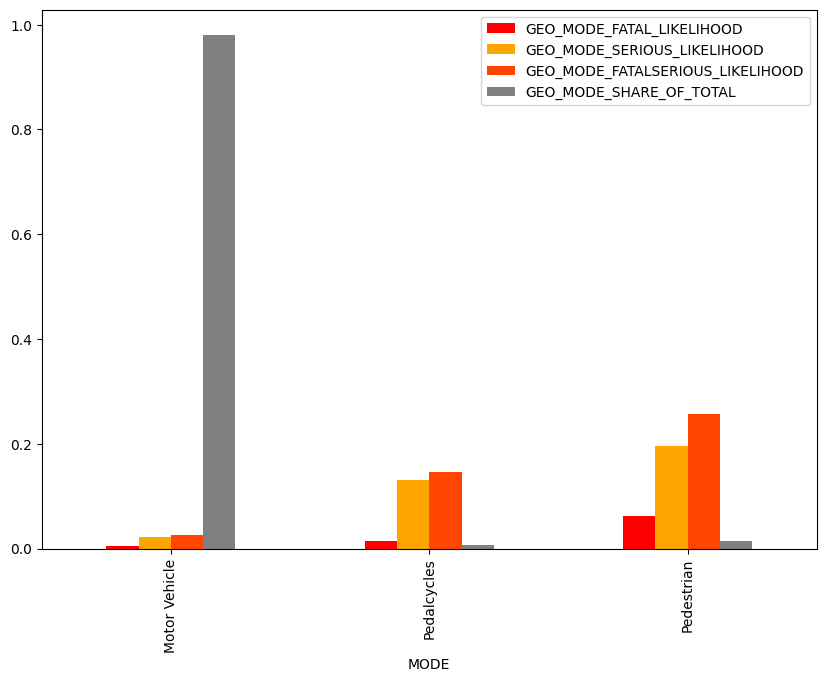

In [38]:
crashSeverityByMode.loc["Region10"] \
    .reset_index() \
    .filter(items=['MODE','GEO_MODE_FATAL_LIKELIHOOD','GEO_MODE_SERIOUS_LIKELIHOOD','GEO_MODE_FATALSERIOUS_LIKELIHOOD','GEO_MODE_SHARE_OF_TOTAL'], axis="columns") \
    .set_index("MODE") \
    .plot.bar(color=["red","orange","orangered","grey"], figsize=(10,7))

## Export data and create resource files

### Crash severity by crash type

In [71]:
outputCrashSeverityByCrashTypeSchema = morpc.frictionless_load_schema(OUTPUT_CRASH_SEVERITY_BY_TYPE_SCHEMA)

In [72]:
outputCrashSeverityByCrashType = crashSeverityByCrashType.copy() \
    .filter(items=["GEO_CRASHTYPE_SHARE_OF_FATAL","GEO_CRASHTYPE_SHARE_OF_SERIOUS","GEO_CRASHTYPE_SHARE_OF_TOTAL"], axis="columns") \
    .reset_index() \
    .melt(id_vars=["GEONAME","CRASH_TYPE_CD"], var_name="VARIABLE", value_name="VALUE")

outputCrashSeverityByCrashType["GEONAME"] = outputCrashSeverityByCrashType["GEONAME"].apply(lambda name:("10-County Region" if name=="Region10" else "{} County".format(name)))

outputCrashSeverityByCrashType = morpc.cast_field_types(outputCrashSeverityByCrashType, outputCrashSeverityByCrashTypeSchema)

outputCrashSeverityByYear.head()

frictionless_cast_field_types | INFO | Casting field GEONAME as type string.
frictionless_cast_field_types | INFO | Casting field CRASH_TYPE_CD as type string.
frictionless_cast_field_types | INFO | Casting field VARIABLE as type string.
frictionless_cast_field_types | INFO | Casting field VALUE as type number.


,GEONAME,YEAR,VARIABLE,VALUE
0,Delaware County,2019,Total crashes,4009.0
1,Delaware County,2020,Total crashes,3174.0
2,Delaware County,2021,Total crashes,3441.0
3,Delaware County,2022,Total crashes,3557.0
4,Delaware County,2023,Total crashes,3485.0


In [73]:
outputCrashSeverityByCrashType.to_csv(OUTPUT_CRASH_SEVERITY_BY_TYPE_PATH, index=False)

In [99]:
outputCrashSeverityByCrashTypeResource = morpc.frictionless_create_resource(OUTPUT_CRASH_SEVERITY_BY_TYPE_FILENAME, 
    resourcePath=OUTPUT_CRASH_SEVERITY_BY_TYPE_RESOURCE,
    title="MORPC Insights | Crash Severity by Crash Type", 
    name="crashes_severity_by_type", 
    description="Summary of vehicle crash severity by county by crash type for counties in the MORPC 10-county region. Variables include the share of total crashes, \
        accounted for by each type plus the share of fatal crashes and share of serious injury crashes.",
    writeResource=True,
    validate=True
)

morpc.frictionless_create_resource | INFO | Format not specified. Using format derived from data file extension: csv
morpc.frictionless_create_resource | INFO | Schema path not specified. Using path derived from data file path: crashSeverityByType.schema.yaml
morpc.frictionless_create_resource | INFO | Writing Frictionless Resource file to output_data\crashSeverityByType.resource.yaml
morpc.frictionless_create_resource | INFO | Validating resource on disk.
morpc.frictionless_validate_resource | INFO | Validating resource on disk (including data and schema). This may take some time.
morpc.frictionless_validate_resource | INFO | Resource is valid


### Crash severity by year

In [76]:
outputCrashSeverityByYearSchema = morpc.frictionless_load_schema(OUTPUT_CRASH_SEVERITY_BY_YEAR_SCHEMA)

In [77]:
outputCrashSeverityByYear = crashSeverityByYear.copy() \
    .filter(items=["GEO_YEAR_TOTAL","GEO_YEAR_FATAL_RATE","GEO_YEAR_SERIOUS_RATE"], axis="columns") \
    .reset_index() \
    .melt(id_vars=["GEONAME","YEAR"], var_name="VARIABLE", value_name="VALUE")

outputCrashSeverityByYear["GEONAME"] = outputCrashSeverityByYear["GEONAME"].apply(lambda name:("10-County Region" if name=="Region10" else "{} County".format(name)))

outputCrashSeverityByYear = morpc.cast_field_types(outputCrashSeverityByYear, outputCrashSeverityByYearSchema)

outputCrashSeverityByYear.head()

frictionless_cast_field_types | INFO | Casting field GEONAME as type string.
frictionless_cast_field_types | INFO | Casting field YEAR as type integer.
frictionless_cast_field_types | INFO | Casting field VARIABLE as type string.
frictionless_cast_field_types | INFO | Casting field VALUE as type number.


,GEONAME,YEAR,VARIABLE,VALUE
0,Delaware County,2019,GEO_YEAR_TOTAL,4009.0
1,Delaware County,2020,GEO_YEAR_TOTAL,3174.0
2,Delaware County,2021,GEO_YEAR_TOTAL,3441.0
3,Delaware County,2022,GEO_YEAR_TOTAL,3557.0
4,Delaware County,2023,GEO_YEAR_TOTAL,3485.0


In [78]:
outputCrashSeverityByYear.to_csv(OUTPUT_CRASH_SEVERITY_BY_YEAR_PATH, index=False)

In [97]:
outputCrashSeverityByYearResource = morpc.frictionless_create_resource(OUTPUT_CRASH_SEVERITY_BY_YEAR_FILENAME, 
    resourcePath=OUTPUT_CRASH_SEVERITY_BY_YEAR_RESOURCE,
    title="MORPC Insights | Crash Severity by Year", 
    name="crashes_severity_by_year", 
    description="Summary of vehicle crash severity by county by year for counties in the MORPC 10-county region. Variables include the total number of crashes, \
        the rate of fatal crashes per 1000 crashes, and the rate of serious injury crashes per 1000 crashes.",
    writeResource=True,
    validate=True
)

morpc.frictionless_create_resource | INFO | Format not specified. Using format derived from data file extension: csv
morpc.frictionless_create_resource | INFO | Schema path not specified. Using path derived from data file path: crashSeverityByYear.schema.yaml
morpc.frictionless_create_resource | INFO | Writing Frictionless Resource file to output_data\crashSeverityByYear.resource.yaml
morpc.frictionless_create_resource | INFO | Validating resource on disk.
morpc.frictionless_validate_resource | INFO | Validating resource on disk (including data and schema). This may take some time.
morpc.frictionless_validate_resource | INFO | Resource is valid


### Crash severity by mode

In [82]:
crashSeverityByMode.head()

GEO_MODE_FATAL  GEO_MODE_POSSIBLE  GEO_MODE_MINOR  \
GEONAME   MODE                                                               
Delaware  Motor Vehicle              61               2084            2297   
          Pedalcycles                 3                 12              37   
          Pedestrian                  5                 21              63   
Fairfield Motor Vehicle              68               1144            1759   
          Pedalcycles                 1                 12              27   

                         GEO_MODE_NOINJ  GEO_MODE_SERIOUS  GEO_MODE_TOTAL  \
GEONAME   MODE                                                              
Delaware  Motor Vehicle           12659               361           17462   
          Pedalcycles                18                17              87   
          Pedestrian                  7                21             117   
Fairfield Motor Vehicle            9253               362           12586   
          Pedalcycles                14                11              65   

                         GEO_FATAL  GEO_SERIOUS  GEO_MINOR  GEO_POSSIBLE  \
GEONAME   MODE                                                             
Delaware  Motor Vehicle         69          399       2397          2117   
          Pedalcycles           69          399       2397          2117   
          Pedestrian            69          399       2397          2117   
Fairfield Motor Vehicle         73          404       1837          1181   
          Pedalcycles           73          404       1837          1181   

                         GEO_NOINJ  GEO_TOTAL  GEO_MODE_FATAL_LIKELIHOOD  \
GEONAME   MODE                                                             
Delaware  Motor Vehicle      12684      17666                   0.003493   
          Pedalcycles        12684      17666                   0.034483   
          Pedestrian         12684      17666                   0.042735   
Fairfield Motor Vehicle       9272      12767                   0.005403   
          Pedalcycles         9272      12767                   0.015385   

                         GEO_MODE_SERIOUS_LIKELIHOOD  \
GEONAME   MODE                                         
Delaware  Motor Vehicle                     0.020673   
          Pedalcycles                       0.195402   
          Pedestrian                        0.179487   
Fairfield Motor Vehicle                     0.028762   
          Pedalcycles                       0.169231   

                         GEO_MODE_FATALSERIOUS_LIKELIHOOD  \
GEONAME   MODE                                              
Delaware  Motor Vehicle                          0.024167   
          Pedalcycles                            0.229885   
          Pedestrian                             0.222222   
Fairfield Motor Vehicle                          0.034165   
          Pedalcycles                            0.184615   

                         GEO_MODE_SHARE_OF_TOTAL  
GEONAME   MODE                                    
Delaware  Motor Vehicle                 0.988452  
          Pedalcycles                   0.004925  
          Pedestrian                    0.006623  
Fairfield Motor Vehicle                 0.985823  
          Pedalcycles                   0.005091

In [85]:
outputCrashSeverityByModeSchema = morpc.frictionless_load_schema(OUTPUT_CRASH_SEVERITY_BY_MODE_SCHEMA)

In [86]:
outputCrashSeverityByMode = crashSeverityByMode.copy() \
    .filter(items=["GEO_MODE_FATAL_LIKELIHOOD","GEO_MODE_SERIOUS_LIKELIHOOD", "GEO_MODE_FATALSERIOUS_LIKELIHOOD", "GEO_MODE_SHARE_OF_TOTAL"], axis="columns") \
    .reset_index() \
    .melt(id_vars=["GEONAME","MODE"], var_name="VARIABLE", value_name="VALUE")

outputCrashSeverityByMode["GEONAME"] = outputCrashSeverityByMode["GEONAME"].apply(lambda name:("10-County Region" if name=="Region10" else "{} County".format(name)))

outputCrashSeverityByMode.head()

,GEONAME,MODE,VARIABLE,VALUE
0,Delaware County,Motor Vehicle,GEO_MODE_FATAL_LIKELIHOOD,0.003493
1,Delaware County,Pedalcycles,GEO_MODE_FATAL_LIKELIHOOD,0.034483
2,Delaware County,Pedestrian,GEO_MODE_FATAL_LIKELIHOOD,0.042735
3,Fairfield County,Motor Vehicle,GEO_MODE_FATAL_LIKELIHOOD,0.005403
4,Fairfield County,Pedalcycles,GEO_MODE_FATAL_LIKELIHOOD,0.015385


In [95]:
outputCrashSeverityByMode.to_csv(OUTPUT_CRASH_SEVERITY_BY_MODE_PATH, index=False)

In [96]:
outputCrashSeverityByModeResource = morpc.frictionless_create_resource(OUTPUT_CRASH_SEVERITY_BY_MODE_FILENAME, 
    resourcePath=OUTPUT_CRASH_SEVERITY_BY_MODE_RESOURCE,
    title="MORPC Insights | Crash Severity by Mode", 
    name="crashes_severity_by_mode", 
    description="Summary of vehicle crash severity by county by mode for counties in the MORPC 10-county region. Variables include the likelihood of a fatal crash, \
        likelihood of a serious injury crash, combined likelihood of a fatal or serious injury crash, and the share of total crashes that is accounted for by the mode.",
    writeResource=True,
    validate=True
)

morpc.frictionless_create_resource | INFO | Format not specified. Using format derived from data file extension: csv
morpc.frictionless_create_resource | INFO | Schema path not specified. Using path derived from data file path: crashSeverityByMode.schema.yaml
morpc.frictionless_create_resource | INFO | Writing Frictionless Resource file to output_data\crashSeverityByMode.resource.yaml
morpc.frictionless_create_resource | INFO | Validating resource on disk.
morpc.frictionless_validate_resource | INFO | Validating resource on disk (including data and schema). This may take some time.
morpc.frictionless_validate_resource | INFO | Resource is valid


## Generate static charts

In [145]:
for f in os.scandir(chartDir):
    os.remove(f)

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'output_data\\charts\\crashSeverityByType-Region10.xlsx'

### Crash severity by crash type

In [143]:
%matplotlib agg

colorset = ['#cc1414', '#f7b602', '#a8a8a8']
    
# Iterate over each geography in data set
for geoName in SELECTED_GEOS:   

    # Extract the data for a single geography
    geoLabel = ("10-County Region" if geoName == "Region10" else "{} County".format(geoName))

    # Extract the data for the geography and the columns required to be displayed on the chart. Sort the data
    # such that the crash types are ordered by share of fatal crashes
    temp = crashSeverityByCrashType.loc[geoName].copy() \
        .filter(items=['GEO_CRASHTYPE_SHARE_OF_FATAL','GEO_CRASHTYPE_SHARE_OF_SERIOUS','GEO_CRASHTYPE_SHARE_OF_TOTAL'], axis="columns") \
        .rename(columns={
            'GEO_CRASHTYPE_SHARE_OF_FATAL':"Share of fatal crashes",
            'GEO_CRASHTYPE_SHARE_OF_SERIOUS':"Share of serious injury crashes",
            'GEO_CRASHTYPE_SHARE_OF_TOTAL':"Share of all crashes"
        }) \
        .sort_values("Share of fatal crashes", ascending=False)

    # Convert the share ratio into a percentage
    for column in ['Share of fatal crashes','Share of serious injury crashes','Share of all crashes']:     
        temp[column] = temp[column] * 100

    # Generate a title string
    title = "Crash Severity by Type of Crash - {}".format(geoLabel)
    ylabel = "Percent of crashes"
    xlabel = None
    yLim = 1.1 * temp[['Share of fatal crashes','Share of serious injury crashes','Share of all crashes']].max().max()
      
    # Create and annotate the plot
    PLOTWIDTH = 8
    fig,ax = plt.subplots(figsize=(PLOTWIDTH,PLOTWIDTH/16*9))

    temp.plot.bar(ax=ax, color=colorset, width=0.8)

    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(ymin=0, ymax=yLim)
    ax.set_yticks([round(tick,0) for tick in ax.get_yticks()])
    labels = [textwrap.fill(label, 15) for label in labels]
    legend = ax.legend(handles[::-1], labels[::-1], loc='upper right', labelspacing=1)
    ax.grid(visible=True, color="lightgrey", axis="y")
    ax.set_axisbelow(True)
       
    # Save the figure to disk as an SVG file
    ax.figure.savefig(os.path.join(chartDir, "crashSeverityByType-{}.svg".format(geoName)), bbox_extra_artists=(legend,), bbox_inches='tight')
    
    plt.close(ax.figure)

    writer = pd.ExcelWriter(os.path.join(chartDir, "crashSeverityByType-{}.xlsx".format(geoName)), engine='xlsxwriter')
    dataOptions = {
        "numberFormat": {
            'CRASH_TYPE_CD': "",
            'Share of fatal crashes': "0",
            'Share of serious injury crashes': "0",
            'Share of all crashes': "0",
        },
        "columnWidth": 32
    }
    chartOptions = {
        "colors": colorset,
        "titles": {
            "chartTitle": title,
            "xTitle": xlabel,
            "yTitle": ylabel
        },
        "xAxisOptions": {
            "num_font": {"size":12},
        },
        "yAxisOptions": {
            "num_font": {"size":14},
            "num_format": "0",
            "name_font": {"size":14}
        },
        "legendOptions":{
            "position":"bottom",
            "font":{"size":14}
        },
        "sizeOptions":{
            "x_scale":1.5,
            "y_scale":2
        }
    }
    morpc.data_chart_to_excel(temp, writer, chartType="column", dataOptions=dataOptions, chartOptions=chartOptions)
    writer.close()    
    
%matplotlib inline

### Crash severity by year

In [ ]:
    #%matplotlib agg

    colorset = ['#cc1414', '#f7b602', '#a8a8a8']
    
    # Iterate over each geography in data set
    #for geoName in SELECTED_GEOS:   
    geoName = "Region10"

    # Extract the data for a single geography
    geoLabel = ("10-County Region" if geoName == "Region10" else "{} County".format(geoName))

    # Extract the data for the geography and the columns required to be displayed on the chart.
    temp = crashSeverityByYear.loc[geoName].copy() \
        .reset_index() \
        .filter(items=["YEAR","GEO_YEAR_TOTAL","GEO_YEAR_FATAL_RATE","GEO_YEAR_SERIOUS_RATE"]) \
        .rename(columns={
            "GEO_YEAR_TOTAL":"Total crashes",
            "GEO_YEAR_FATAL_RATE":"Fatal crash rate",
            "GEO_YEAR_SERIOUS_RATE":"Serious injury crash rate"
        })

    # Generate a title string
    title = "Crash Severity by Year - {}".format(geoLabel)
    yMax = temp[["Fatal crash rate","Serious injury crash rate"]].max().max() * 1.1

    lineWidth = 3
    markerSize = 7

    # Create and annotate the plot
    PLOTWIDTH = 8
    fig,ax1 = plt.subplots(figsize=(PLOTWIDTH,PLOTWIDTH/16*9))
    ax2 = ax1.twinx()
    ax1.bar(temp["YEAR"], temp["Total crashes"], color=colorset[2])
    ax2.plot(temp["YEAR"], temp['Fatal crash rate'], color=colorset[0], linewidth=lineWidth, marker='o', markersize=markerSize)
    ax2.plot(temp["YEAR"], temp['Serious injury crash rate'], color=colorset[1], linewidth=lineWidth, marker='o', markersize=markerSize)
    ax2.set_ylim(ymin=0, ymax=yMax)
    ax2.set_ylabel("Crash rate (per 1000 crashes)")
    ax1.set_ylabel("Total crashes")
    ax1Handles, ax1Labels = ax1.get_legend_handles_labels()
    ax2Handles, ax2Labels = ax2.get_legend_handles_labels()
    legend = fig.legend(ax1Handles+ax2Handles, ax1Labels+ax2Labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3)
    ax1.set_title(title, fontsize=14)
    ax1.set_axisbelow(True)
    ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
       
    # Save the figure to disk as an SVG file
    ax1.figure.savefig(os.path.join(chartDir, "crashSeverityByYear-{}.svg".format(geoName)), bbox_extra_artists=(legend,), bbox_inches='tight')
    
    plt.close(ax1.figure)

    writer = pd.ExcelWriter(os.path.join(chartDir, "crashSeverityByType-{}.xlsx".format(geoName)), engine='xlsxwriter')
    dataOptions = {
        "numberFormat": {
            'YEAR': "0",
            'Fatal crash rate': "0",
            'Serious injury crash rate': "0",
            'Total crashes': "#,##0",
        },
        "columnWidth": 30
    }
    chartOptions = {
        "colors": {
            'Fatal crash rate': colorset[0],
            'Serious injury crash rate': colorset[1],
            'Total crashes': colorset[2],
        },
        "titles": {
            "chartTitle": title,
            "xTitle": xlabel,
            "yTitle": ylabel
        },
        "xAxisOptions": {
            "num_font": {"size":12},
        },
        "yAxisOptions": {
            "num_font": {"size":14},
            "num_format": "0",
            "name_font": {"size":14}
        },
        "legendOptions":{
            "position":"bottom",
            "font":{"size":14}
        },
        "sizeOptions":{
            "x_scale":1.5,
            "y_scale":1.5
        }
    }
    morpc.data_chart_to_excel(temp, writer, chartType="column", dataOptions=dataOptions, chartOptions=chartOptions)
    writer.close()    
    
%matplotlib inline

### Crash severity by mode

### Motorized vs non-motorized fatalities (obsolete)

### Crashes by injury severity (obsolete)

### Injury severity by crash type (obsolete)

## Generate Insights catalog content

The content in the Insights platform is controlled by a catalog spreadsheet. Each tile to be displayed in the platform must have a record in the catalog.  This section will create the records for the tiles that display the alternative fuel station data.  Eventually this function will be performed by a separate staging script.

First specify the column names used in the catalog.

In [ ]:
zcolumnNames=["TileID","TilesetID","GeographyType","GeographyName","Category","Headline","Commentary","ThumbnailURL","Contributor","Vintage","UpdateInterval","ShareURL","DataProductURL","MoreInformationURL"]

Create a new dataframe containing only the geographies for which thumbnail images were produced in the section above.

In [ ]:
catalog = pd.DataFrame(index=SELECTED_GEOS, columns=columnNames)
catalog.index.name = "geoLabel"
catalog = catalog.reset_index()

Convert the shortened geography labels to longer, more human-readable names.

In [ ]:
catalog["GeographyName"] = catalog["geoLabel"].apply(lambda x:("10-County Region" if x == "Region10" else "{} County".format(x)))

Add the appropriate GeographyType values.

In [ ]:
catalog["GeographyType"] = catalog["geoLabel"].apply(lambda x:("Region" if x == "Region10" else "County"))

Populate some placeholder fields.

In [ ]:
catalog["TileID"] = None
catalog["TilesetID"] = "TBD-Fatalities"
catalog["Category"] = None
catalog["Headline"] = "TBD"
catalog["Commentary"] = "TBD"

Generate the URL for the thumbnail images. These will be hosted in GitHub and will be indexed by GEOIDFQ.

In [ ]:
catalog["ThumbnailURL"] = catalog["geoLabel"].apply(lambda name:"https://raw.githubusercontent.com/morpc-insights/insights-crashes/refs/heads/main/output_data/charts/fatalities-{}.svg".format(name))

Populate some other simple metadata.  Vintage in this case refers to the year that the content was published in Insights. This is to give readers an idea of how old it is.  UpdateInterval gives them an idea of when to expect the next version. ShareURL is a placeholder for now.

In [ ]:
catalog["Contributor"] = "Mid-Ohio Regional Planning Commission"
catalog["Vintage"] = str(datetime.date.today().year)
catalog["UpdateInterval"] = "annually"
catalog["ShareURL"] = None

Generate the data product URL.  This points to an ArcGIS Dashboard that accepts URL parameters.  The geography name is passed as a parameter to tell the app to load the data for a particular geography.

In [ ]:
catalog["DataProductURL"] = catalog["GeographyName"].apply(lambda name:"https://www.arcgis.com/apps/dashboards/393332b21d3242f99896e13bda9acac8#region={}".format(name))

Generate the URLs that point to the fact sheet.

In [ ]:
catalog["MoreInformationURL"] = "https://morpc1-my.sharepoint.com/:w:/g/personal/aporr_morpc_org/EdF9OgInIZdOk9Sz3aJSVT8BPvXp4N495QUN2PvK5NBBjQ?e=b30KGA"

Extract only the required columns.

In [ ]:
catalog = catalog.filter(items=columnNames, axis="columns")

Inspect the listing.

In [ ]:
catalog.head()

Add records for the Injuries by Severity tileset, which are identical to the Fatalities tileset but have different thumbnail and data product URLs.

In [ ]:
temp = catalog.copy()
temp["ThumbnailURL"] = temp["ThumbnailURL"].str.replace("fatalities-", "injuries-")
temp["DataProductURL"] = temp["DataProductURL"].str.replace("393332b21d3242f99896e13bda9acac8","9ef238da0abf49b9801558cc63c72487")
temp["TilesetID"] = temp["TilesetID"].str.replace("Fatalities", "Injuries")
catalog = pd.concat([catalog, temp], axis="index")

Save the catalog to an Excel spreadsheet.

In [ ]:
catalog.to_excel("catalog.xlsx", index=False)

It is necessary to manually add these records to the master catalog or update the records already therein.  See the following file in GitHub:

https://github.com/morpc/morpc-insights/blob/main/catalog/morpc_insights_catalog.xlsx
